imports

In [25]:
import shutil
import os
import numpy as np
import zipfile
import pandas as pd
import seaborn as sns
from pyexpat import features
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split



In [26]:
import os
print(os.listdir())


['Gauge_attributes.csv', 'ID_228_analysis_2002.csv', 'preprocessing.ipynb', 'random-data-selection.py', 'selected_randoms-100.zip']


load data

In [27]:


zip_path = "selected_randoms-100.zip"

df_list = []

with zipfile.ZipFile(zip_path) as z:
    for file in z.namelist():
        if file.endswith(".csv"):
            temp = pd.read_csv(z.open(file), sep=";")
            temp["location_id"] = int(file.split("_")[-1].replace(".csv", ""))
            df_list.append(temp)

df_merged = pd.concat(df_list, ignore_index=True)

df_merged.head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,location_id
0,1981,1,1,1,2.5,-0.1,-2.9,-0.5,-3.4,-6.5,...,126,20,60,39,94590.0,0.48,8.10,0.40,0.4,310
1,1981,1,2,2,0.8,-1.1,-2.7,-1.3,-3.6,-5.8,...,72,14,42,25,94662.0,0.36,7.99,0.39,0.4,310
2,1981,1,3,3,5.3,3.4,1.1,2.1,0.4,-0.9,...,126,22,51,22,93411.0,0.15,13.91,0.40,0.4,310
3,1981,1,4,4,3.0,1.2,-1.0,1.9,-0.5,-2.3,...,145,29,70,43,93118.0,0.32,6.30,0.41,0.4,310
4,1981,1,5,5,-1.1,-3.0,-4.6,-2.7,-5.9,-7.9,...,75,16,67,43,93685.0,0.63,8.96,0.41,0.4,310


null value analysis ( graphs stats so on)

In [28]:
print(df_merged.isnull().sum())


YYYY                       0
MM                         0
DD                         0
DOY                        0
2m_temp_max                0
2m_temp_mean               0
2m_temp_min                0
2m_dp_temp_max             0
2m_dp_temp_mean            0
2m_dp_temp_min             0
10m_wind_u                 0
10m_wind_v                 0
fcst_alb                   0
lai_high_veg               0
lai_low_veg                0
swe                        0
surf_net_solar_rad_max     0
surf_net_solar_rad_mean    0
surf_net_therm_rad_max     0
surf_net_therm_rad_mean    0
surf_press                 0
total_et                   0
prec                       0
volsw_123                  0
volsw_4                    0
location_id                0
dtype: int64


The meteorological time series have no gaps.

data analysis distribution correlations and so on tables and graphs

In [29]:
df_merged.columns = df_merged.columns.str.strip()

df_merged.head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,location_id
0,1981,1,1,1,2.5,-0.1,-2.9,-0.5,-3.4,-6.5,...,126,20,60,39,94590.0,0.48,8.10,0.40,0.4,310
1,1981,1,2,2,0.8,-1.1,-2.7,-1.3,-3.6,-5.8,...,72,14,42,25,94662.0,0.36,7.99,0.39,0.4,310
2,1981,1,3,3,5.3,3.4,1.1,2.1,0.4,-0.9,...,126,22,51,22,93411.0,0.15,13.91,0.40,0.4,310
3,1981,1,4,4,3.0,1.2,-1.0,1.9,-0.5,-2.3,...,145,29,70,43,93118.0,0.32,6.30,0.41,0.4,310
4,1981,1,5,5,-1.1,-3.0,-4.6,-2.7,-5.9,-7.9,...,75,16,67,43,93685.0,0.63,8.96,0.41,0.4,310


In [30]:
#TODO delete dates too ?
print(df_merged)
df_merged = df_merged.rename(columns={'YYYY':'year', 'MM':'month', 'DD':'day'})
df_merged['date'] = pd.to_datetime(df_merged[['year','month','day']])
df_merged = df_merged.set_index('date')
df_merged = df_merged.drop(columns=['year','month','day'])
target= df_merged['prec']
features= df_merged.drop(columns=['prec'])


         YYYY  MM  DD  DOY  2m_temp_max  2m_temp_mean  2m_temp_min  \
0        1981   1   1    1          2.5          -0.1         -2.9   
1        1981   1   2    2          0.8          -1.1         -2.7   
2        1981   1   3    3          5.3           3.4          1.1   
3        1981   1   4    4          3.0           1.2         -1.0   
4        1981   1   5    5         -1.1          -3.0         -4.6   
...       ...  ..  ..  ...          ...           ...          ...   
1424395  2019  12  27  361          4.1           3.1          1.1   
1424396  2019  12  28  362          0.8          -0.9         -2.9   
1424397  2019  12  29  363          2.1          -2.2         -4.1   
1424398  2019  12  30  364          4.9          -0.8         -3.7   
1424399  2019  12  31  365          5.8           0.9         -2.3   

         2m_dp_temp_max  2m_dp_temp_mean  2m_dp_temp_min  ...  \
0                  -0.5             -3.4            -6.5  ...   
1                  -1.3      

In [31]:
correlations = features.corrwith(target).sort_values(ascending=False)
print(correlations)

10m_wind_u                 0.223898
lai_high_veg               0.174248
2m_dp_temp_mean            0.157797
2m_dp_temp_min             0.156410
2m_dp_temp_max             0.142924
2m_temp_min                0.121645
volsw_123                  0.055586
2m_temp_mean               0.043607
volsw_4                    0.033374
DOY                        0.014734
lai_low_veg                0.011233
total_et                   0.010198
fcst_alb                   0.000188
swe                       -0.001380
2m_temp_max               -0.029726
location_id               -0.087631
10m_wind_v                -0.088442
surf_press                -0.118341
surf_net_solar_rad_mean   -0.205079
surf_net_solar_rad_max    -0.220782
surf_net_therm_rad_max    -0.486688
surf_net_therm_rad_mean   -0.504787
dtype: float64


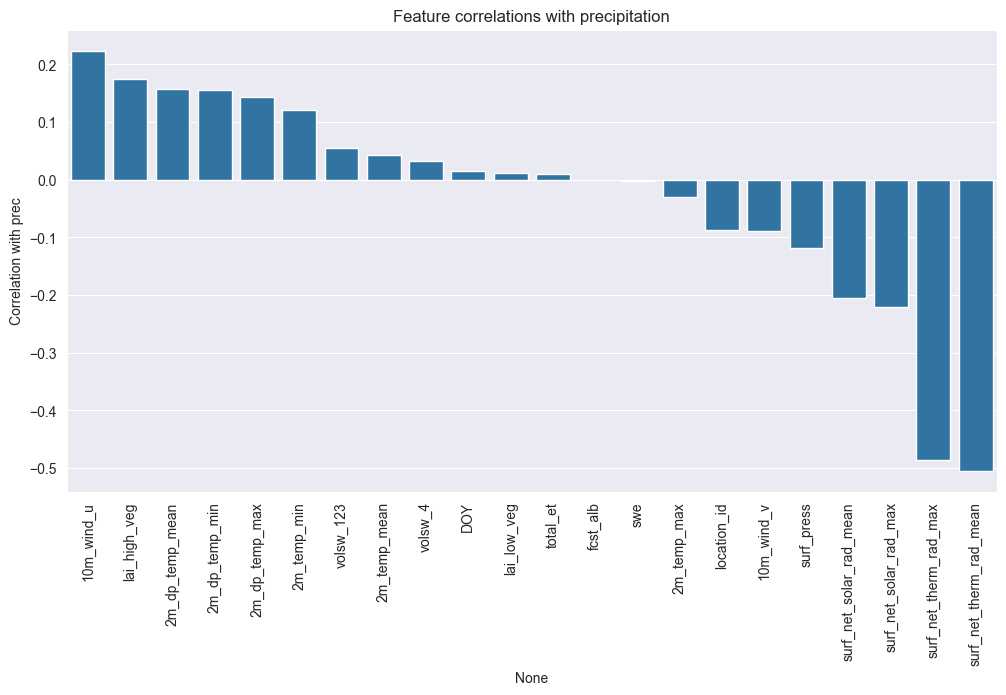

In [32]:
plt.figure(figsize=(12,6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
plt.ylabel("Correlation with prec")
plt.title("Feature correlations with precipitation")
plt.show()

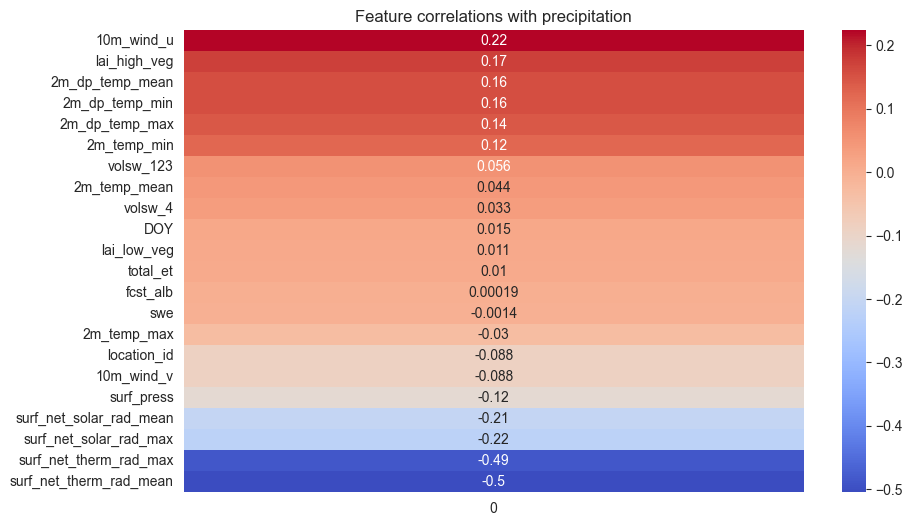

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(correlations.to_frame(), annot=True, cmap="coolwarm")
plt.title("Feature correlations with precipitation")
plt.show()

C:\Users\Patrick\AppData\Local\Temp\ipykernel_7728\1729382525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["prec"] = target


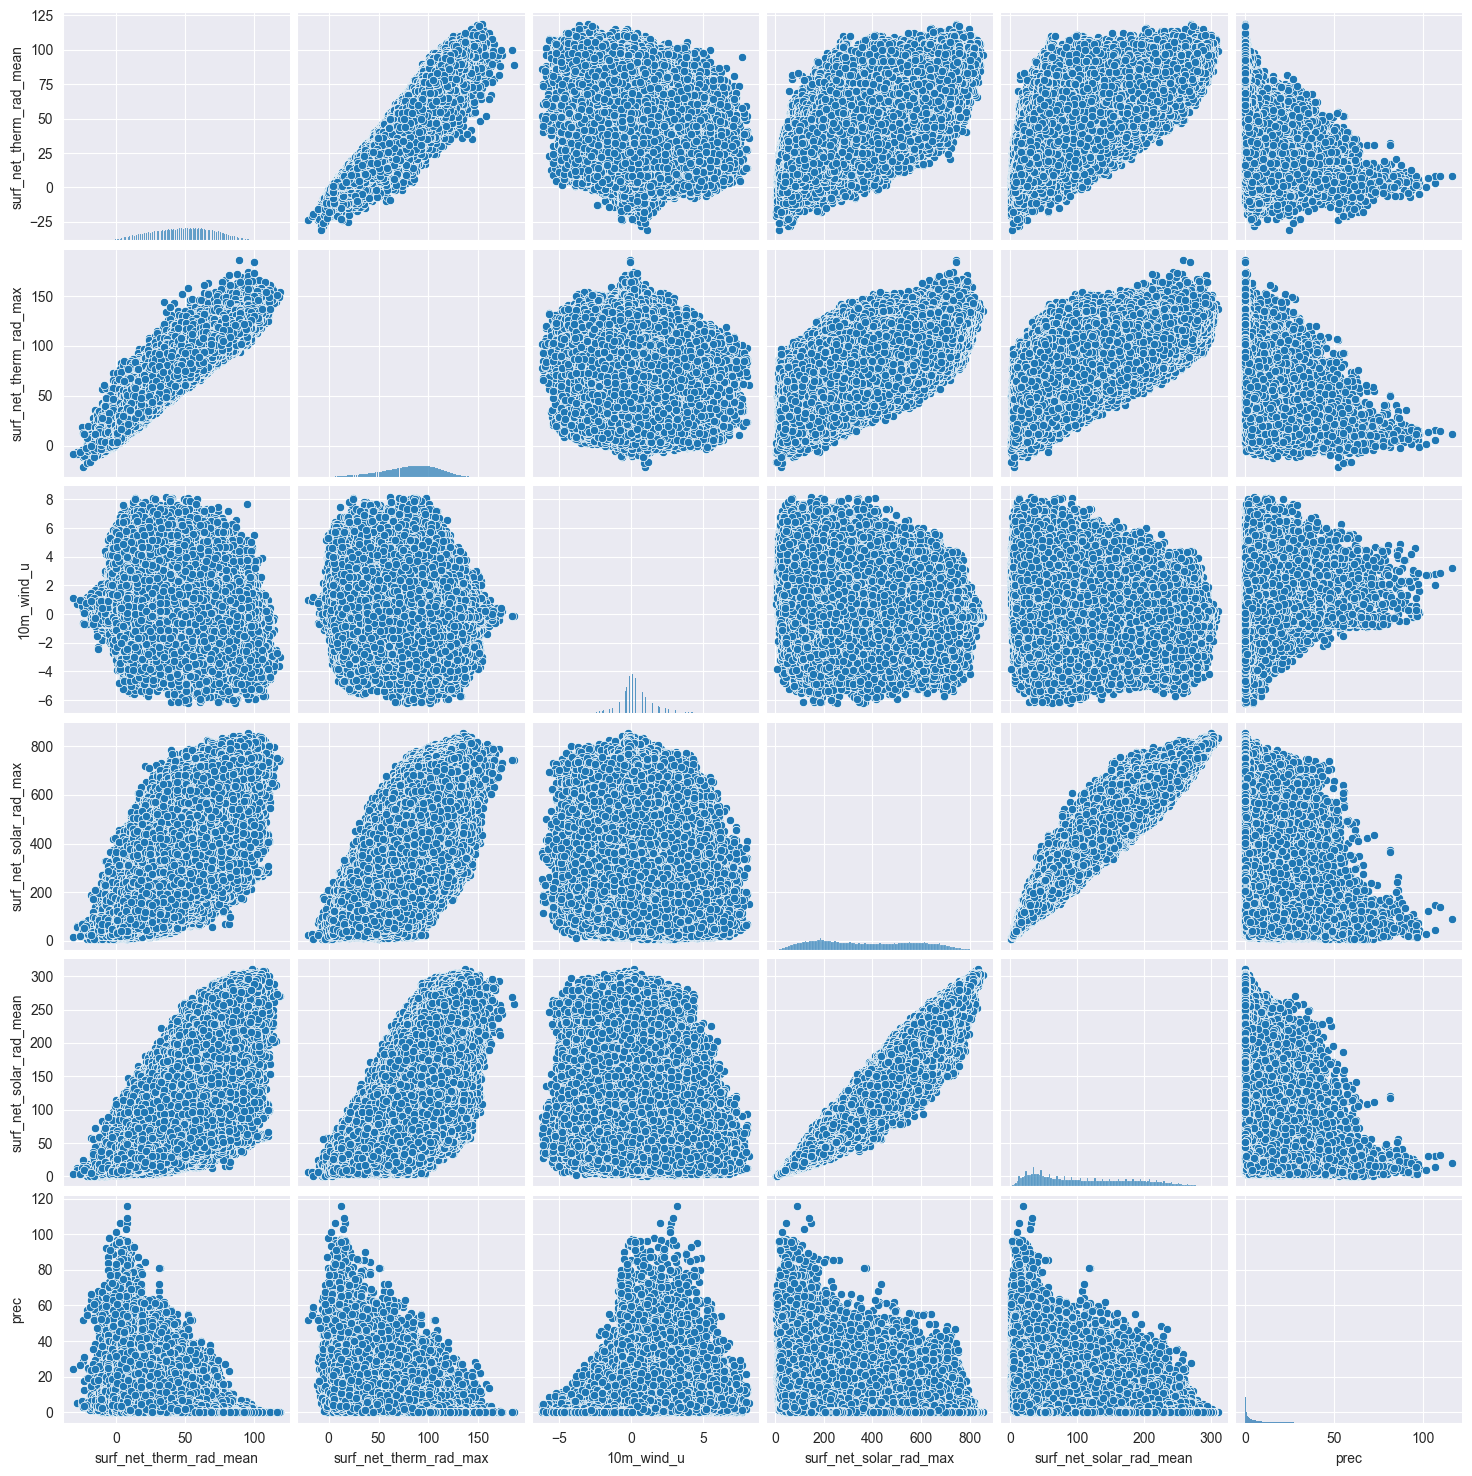

In [34]:
subset = features[list(correlations.abs().sort_values(ascending=False).index[:5])]
subset["prec"] = target
sns.pairplot(subset)
plt.show()

data preprocessing impute missing values normalize and so on

split data

In [35]:

X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [36]:
from sklearn.preprocessing import MinMaxScaler
cols_to_normalize = [

    'swe','surf_net_solar_rad_max','surf_net_solar_rad_mean',
    'surf_net_therm_rad_max','surf_net_therm_rad_mean',
    'surf_press'
]
scaler = MinMaxScaler()
#fit to the data we know
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])

#use it on data we dont know
X_val[cols_to_normalize] = scaler.transform(X_val[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

X_train

,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,...,swe,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,volsw_123,volsw_4,location_id
date,,,,,,,,,,,,,,,,,,,,,
1989-11-10,314,8.4,3.3,-1.2,2.4,0.8,-1.9,-0.2,2.0,0.13,...,0.000006,0.367925,0.233010,0.630542,0.706667,0.877999,0.39,0.48,0.45,651
2012-05-01,122,22.5,16.8,11.0,13.5,9.9,6.6,-0.3,0.8,0.13,...,0.000000,0.816038,0.773463,0.630542,0.766667,0.754288,3.68,0.34,0.41,260
2013-05-07,127,18.4,14.4,10.3,14.4,12.2,10.0,-0.3,0.3,0.15,...,0.000000,0.530660,0.466019,0.389163,0.506667,0.827626,2.26,0.31,0.34,658
2017-05-17,137,19.8,16.0,9.9,12.8,10.5,8.1,-0.5,0.3,0.14,...,0.000000,0.604953,0.524272,0.561576,0.566667,0.799347,2.38,0.38,0.38,591
1995-03-15,74,5.8,2.4,-1.7,2.4,0.0,-3.5,1.3,1.2,0.19,...,0.000373,0.219340,0.171521,0.359606,0.400000,0.805811,0.96,0.39,0.41,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988-08-18,231,23.4,17.7,11.3,12.9,11.1,10.1,-0.1,0.2,0.13,...,0.000000,0.775943,0.708738,0.699507,0.766667,0.727222,3.36,0.27,0.36,436
1992-08-29,242,25.3,18.7,13.3,15.6,13.5,12.5,1.2,0.3,0.16,...,0.000000,0.609670,0.472492,0.517241,0.560000,0.724487,2.70,0.39,0.46,743
1991-03-26,85,5.6,3.7,1.7,4.9,3.5,1.7,-1.2,-0.9,0.13,...,0.000253,0.212264,0.165049,0.231527,0.306667,0.675451,0.99,0.40,0.41,715


discussing data quality, why knowing the data quality is important and why data engineering is important

arima

C:\Users\Patrick\PycharmProjects\PythonProject1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Patrick\PycharmProjects\PythonProject1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Patrick\PycharmProjects\PythonProject1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Patrick\PycharmProjects\PythonProject1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monoto

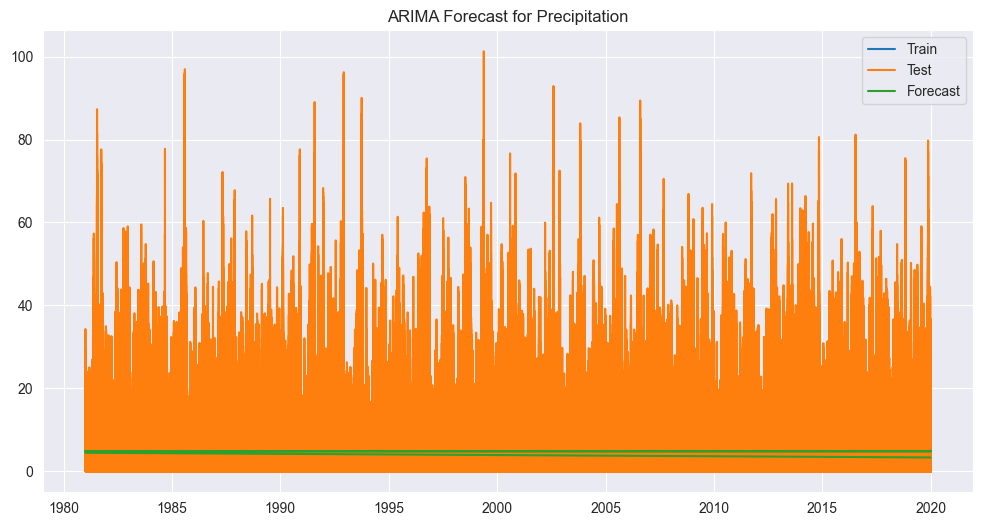

In [37]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

ts = df_merged['prec'].dropna()

split_point = int(len(ts) * 0.7)
ts_train = ts.iloc[:split_point]
ts_test = ts.iloc[split_point:]

model = ARIMA(ts_train, order=(2,1,2))
fit = model.fit()

forecast = fit.forecast(steps=len(ts_test))

plt.figure(figsize=(12,6))
plt.plot(ts_train[-200:], label="Train")
plt.plot(ts_test, label="Test")
plt.plot(ts_test.index, forecast, label="Forecast")
plt.title("ARIMA Forecast for Precipitation")
plt.legend()
plt.show()
